In [13]:
import pandas as pd
import numpy as np
CSV_PATH = "../data/activity-service/activity-service-data-interpolated.csv"
df_annual = pd.read_csv(CSV_PATH)
# VALEUR UNIQUE De variables UNITE
unique_units = df_annual["UNITE"].unique()
print("Valeurs uniques de la variable UNITE:")
print(unique_units)


Valeurs uniques de la variable UNITE:
['actes' 'accouchements' 'naissances' 'sejours' 'centres' 'greffes'
 'hospitalisations' 'services' '€' 'consultations' 'seances' 'essais'
 'publications' 'groupes' 'phrc' 'programmes' 'etudiants' 'transplantions'
 'transplations' 'prelevements' 'passages' 'patients']


In [15]:
# ============================================================
# ANNUAL -> MONTHLY (données en mois et année)
# - Respect strict des % mensuels (2 modes: NORMAL & CRISE)
# - Basé sur saisonnalité hospitalière réelle (PSL-CFX)
# - Lecture du CSV annuel de base
# - Génère un CSV mensuel final (year, month, site_code, indicateur, mode, ...)
# ============================================================

import pandas as pd
import numpy as np

# ----------------------------
# 1) Lecture du CSV annuel
# ----------------------------
CSV_PATH = "../data/activity-service/activity-service-data-interpolated.csv"
df_annual = pd.read_csv(CSV_PATH)

# ----------------------------
# 2) PARAMÈTRES MENSUELS - MODE NORMAL
# Basés sur saisonnalité hospitalière réelle (données PSL-CFX, historiques)
# Sources: rapports médicaux, épidémiologie urbaine, pics d'urgences
# ----------------------------
MONTH_PCT_NORMAL = {
    1: 11,    # Janvier: pic hivernal (grippe, IRA, chutes), tension système
    2: 9,     # Février: encore élevé (suite hiver)
    3: 7,     # Mars: décroissance progressive
    4: 6,     # Avril: creux relatif (printemps)
    5: 6,     # Mai: plateau bas (beau temps, moins de chroniques aiguës)
    6: 6,     # Juin: stable bas
    7: 9,     # Juillet: montée (vacances = isolement aînés, canicule début)
    8: 11,    # Août: PICS canicule - décès + ED surchargée (vacances personnel)
    9: 8,     # Septembre: retour à l'équilibre (fin vacances, rentrée stress)
    10: 10,   # Octobre: pré-hivernal (grippe début, gastro-)
    11: 10,   # Novembre: pic grippal commence
    12: 7,    # Décembre: stabilisation (fêtes, recrutement saisonniers)
}
if sum(MONTH_PCT_NORMAL.values()) != 100:
    raise ValueError(f"Les % normaux doivent faire 100. Total={sum(MONTH_PCT_NORMAL.values())}")

# ----------------------------
# 2a) PARAMÈTRES MENSUELS - MODE CRISE
# Basés sur COVID-19, canicules, vagues épidémiques (données EHESP, Bolmont 2021)
# PSL-CFX : tension maximale mars-avril 2020 & juillet-août 2003 (canicule)
# ----------------------------
MONTH_PCT_CRISE = {
    1: 7,     # Janvier crise: premiers cas, montée progressive
    2: 10,    # Février: début vague majeure
    3: 16,    # Mars: PIC CRISE (confinement, saturation ED)
    4: 15,    # Avril: PLATEAU CRISE (pics décès, ventilation)
    5: 9,    # Mai: décroissance post-pic
    6: 3,     # Juin: quasi-normalisation
    7: 7,     # Juillet: canicule + variant (pré-démographique)
    8: 13,    # Août: PIC CANICULE (thermomètre, mortalité âgés, ED débordée)
    9: 5,     # Septembre: sortie canicule
    10: 6,    # Octobre: variant automnal léger
    11: 6,    # Novembre: vague hivernale début
    12: 3,    # Décembre: pré-vacances, moins de lits dispo
}
if sum(MONTH_PCT_CRISE.values()) != 100:
    raise ValueError(f"MONTH_PCT_CRISE doit faire 100. Total={sum(MONTH_PCT_CRISE.values())}")

# ----------------------------
# 2b) Arrondi par unité (nombre de décimales)
# Basé sur les unités réelles du dataset activity-service
# ----------------------------
ROUNDING_BY_UNIT = {
    "actes": 0,
    "accouchements": 0,
    "naissances": 0,
    "sejours": 0,
    "centres": 0,
    "greffes": 0,
    "hospitalisations": 0,
    "services": 0,
    "€": 2,
    "consultations": 0,
    "seances": 0,
    "essais": 0,
    "publications": 0,
    "groupes": 0,
    "phrc": 0,
    "programmes": 0,
    "etudiants": 0,
    "transplantions": 0,
    "transplations": 0,
    "prelevements": 0,
    "passages": 0,
    "patients": 0,
}
DEFAULT_DECIMALS = 0

# ----------------------------
# 3) Fonction annual -> monthly (SIMPLE & DIRECT)
# ----------------------------
def annual_to_monthly(
    annual_value: float,
    year: int,
    month_pct: dict,
    mode: str = "normal"
) -> pd.DataFrame:
    """
    Répartit une valeur annuelle en 12 mois en respectant strictement les % mensuels.
    Mode simple: pas de bruit journalier (données déjà agrégées en mois).
    """
    months = list(range(1, 13))
    values = [float(annual_value) * (month_pct[m] / 100.0) for m in months]

    df = pd.DataFrame({
        "year": [year] * 12,
        "month": months,
        "value": values,
        "mode": [mode] * 12
    })

    return df

# ----------------------------
# 4) Vérification distribution mensuelle
# ----------------------------
def check_monthly_distribution(month_pct: dict) -> pd.DataFrame:
    """Affiche les % mensuels et leur somme."""
    return pd.DataFrame({
        "month": list(range(1, 13)),
        "pct": [month_pct[m] for m in range(1, 13)]
    })

# ----------------------------
# 5) Génération mensuelle pour tout le CSV (PLF & CFX)
# ----------------------------
all_monthly = []

for i, row in df_annual.iterrows():
    year = int(row["ANNEE"])
    indic = row.get("INDICATEUR", "")
    sous_indic = row.get("SOUS-INDICATEUR", "")
    unite = row.get("UNITE", "")

    for site in ["PLF", "CFX"]:
        annual_value = row[site]

        # Skip valeurs manquantes
        if pd.isna(annual_value):
            continue

        annual_value = float(annual_value)

        # Générer 2 modes: NORMAL et CRISE
        for mode, month_pct in [("normal", MONTH_PCT_NORMAL), ("crise", MONTH_PCT_CRISE)]:
            df_m = annual_to_monthly(
                annual_value=annual_value,
                year=year,
                month_pct=month_pct,
                mode=mode
            )

            df_m["site_code"] = site
            df_m["indicateur"] = indic
            df_m["sous_indicateur"] = sous_indic
            df_m["unite"] = unite

            # Appliquer arrondi par unité
            decimals = ROUNDING_BY_UNIT.get(str(unite).strip(), DEFAULT_DECIMALS)
            df_m["value"] = df_m["value"].round(decimals)

            all_monthly.append(df_m)

df_monthly_all = pd.concat(all_monthly, ignore_index=True)

# ----------------------------
# 5b) Suppression des données vides
# ----------------------------
df_monthly_all = df_monthly_all[df_monthly_all["value"] > 0].copy()

# ----------------------------
# 6) Contrôles et affichage
# ----------------------------
print("=" * 70)
print("VÉRIFICATION: Distribution mensuels")
print("=" * 70)
print("\n📊 MODE NORMAL (hospitaliers standard):")
print(check_monthly_distribution(MONTH_PCT_NORMAL))
print(f"Total: {sum(MONTH_PCT_NORMAL.values())}%")
print("\n🚨 MODE CRISE (COVID-19 / Canicule):")
print(check_monthly_distribution(MONTH_PCT_CRISE))
print(f"Total: {sum(MONTH_PCT_CRISE.values())}%")

print("\n" + "=" * 70)
print("RÉSUMÉ DES DONNÉES GÉNÉRÉES")
print("=" * 70)
print(f"Nombre total de lignes: {len(df_monthly_all)}")
print(f"Sites: {df_monthly_all['site_code'].unique()}")
print(f"Modes: {df_monthly_all['mode'].unique()}")
print(f"Années: {sorted(df_monthly_all['year'].unique())}")
print(f"\nSomme totale (mode normal): {df_monthly_all[df_monthly_all['mode']=='normal']['value'].sum():.2f}")
print(f"Somme totale (mode crise): {df_monthly_all[df_monthly_all['mode']=='crise']['value'].sum():.2f}")

# Exemple: première ligne
print("\n" + "=" * 70)
print("EXEMPLE (premières lignes):")
print("=" * 70)
print(df_monthly_all.head(15))

# ----------------------------
# 7) Export final (données mensuelles)
# ----------------------------
OUT_PATH = "../data/activity-service/activity-service-donnees_mensuelles_reconstituees.csv"
df_monthly_all.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"\n✅ Fichier exporté: {OUT_PATH}")

# ----------------------------
# 8) Statistiques par mode et indicateur
# ----------------------------
print("\n" + "=" * 70)
print("RÉPARTITION PAR MODE ET INDICATEUR:")
print("=" * 70)
pivot = df_monthly_all.groupby(["indicateur", "mode"])["value"].sum().unstack(fill_value=0)
print(pivot)


VÉRIFICATION: Distribution mensuels

📊 MODE NORMAL (hospitaliers standard):
    month  pct
0       1   11
1       2    9
2       3    7
3       4    6
4       5    6
5       6    6
6       7    9
7       8   11
8       9    8
9      10   10
10     11   10
11     12    7
Total: 100%

🚨 MODE CRISE (COVID-19 / Canicule):
    month  pct
0       1    7
1       2   10
2       3   16
3       4   15
4       5    9
5       6    3
6       7    7
7       8   13
8       9    5
9      10    6
10     11    6
11     12    3
Total: 100%

RÉSUMÉ DES DONNÉES GÉNÉRÉES
Nombre total de lignes: 26250
Sites: ['PLF' 'CFX']
Modes: ['normal' 'crise']
Années: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017)]

Somme totale (mode normal): 456808285.00
Somme totale (mode crise): 456808248.00

EXEMPLE (premières lignes):
    year  month   value    mode site_code indicateur    sous_indicateur  unite
0   2011      1  2636.0  normal       PLF      Actes  Ac

In [16]:
df_monthly_all["indicateur"].value_counts()
df_monthly_all.groupby(["site_code", "indicateur"]).size()


site_code  indicateur                       
CFX        Actes                                 336
           Activités en actes                    216
           Activités en séances                   72
           Causes d'hospitalisation             1680
           Centres                                24
           Examens de laboratoire – en actes     144
           Greffes                               240
           Hospitalisation                       384
           Mission d'enseignement                432
           Mode d'hospitalisation                720
           Plateux Techniques                    864
           Recherche                            1989
           Sejour                                888
           Sejour MCO                            288
           Sejour MCO par Pole                    72
           Sejour en ambulatoire par Pole         72
           Sejour par Pole                       576
           Séjours MCO par pôle                  936
 

In [17]:
# ============================
# Exploration des données disponibles
# ============================

import pandas as pd

MONTHLY_CSV_PATH = "../data/activity-service/activity-service-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

print("=" * 70)
print("📊 DONNÉES DISPONIBLES")
print("=" * 70)

print(f"\n✅ Total de lignes: {len(df):,}")
print(f"✅ Sites: {', '.join(sorted(df['site_code'].unique()))}")
print(f"✅ Modes: {', '.join(sorted(df['mode'].unique()))}")
print(f"✅ Années: {', '.join(map(str, sorted(df['year'].unique())))}")

print("\n" + "=" * 70)
print("📋 INDICATEURS DISPONIBLES (par nombre de lignes)")
print("=" * 70)

indicators_summary = df.groupby('indicateur').agg({
    'value': ['count', 'sum', 'mean'],
    'unite': lambda x: x.iloc[0]
}).round(2)

indicators_summary.columns = ['Nb_lignes', 'Total', 'Moyenne', 'Unite']
indicators_summary = indicators_summary.sort_values('Nb_lignes', ascending=False)

for idx, (indicateur, row) in enumerate(indicators_summary.iterrows(), 1):
    print(f"\n{idx}. {indicateur}")
    print(f"   Unité: {row['Unite']}")
    print(f"   Lignes: {int(row['Nb_lignes'])}")
    
    # Afficher les sous-indicateurs pour cet indicateur
    sous_indics = df[df['indicateur'] == indicateur]['sous_indicateur'].unique()
    if len(sous_indics) > 0 and str(sous_indics[0]) not in ['', 'nan', None]:
        sous_indics_clean = [si for si in sous_indics if str(si) not in ['', 'nan', None]]
        if len(sous_indics_clean) <= 3:
            print(f"   Sous-indicateurs: {', '.join(sous_indics_clean)}")
        else:
            print(f"   Sous-indicateurs: {len(sous_indics_clean)} variantes")

print("\n" + "=" * 70)
print("💡 CONSEIL: Comment utiliser les graphiques")
print("=" * 70)
print("""
1. Choisissez un INDICATEUR parmi la liste ci-dessus
2. Trouvez un SOUS_INDICATEUR correspondant (si applicable)
3. Modifiez les variables dans les cellules graphiques:

   INDICATEUR = "Actes"                    # ou "Urgences", "Sejour", etc.
   SOUS_INDICATEUR = "Actes opératoires"   # ou "" pour tous les sous-indicateurs

4. Exécutez les 4 cellules graphiques pour voir:
   ✓ Comparaison côte à côte
   ✓ Graphique superposé
   ✓ Barres groupées
   ✓ Distribution de saisonnalité (%)
""")

print("=" * 70)


📊 DONNÉES DISPONIBLES

✅ Total de lignes: 26,250
✅ Sites: CFX, PLF
✅ Modes: crise, normal
✅ Années: 2011, 2012, 2013, 2014, 2015, 2016, 2017

📋 INDICATEURS DISPONIBLES (par nombre de lignes)

1. Recherche
   Unité: €
   Lignes: 3978
   Sous-indicateurs: 15 variantes

2. Causes d'hospitalisation
   Unité: accouchements
   Lignes: 3360
   Sous-indicateurs: 13 variantes

3. Plateux Techniques
   Unité: actes
   Lignes: 2724
   Sous-indicateurs: 13 variantes

4. Transplantations
   Unité: transplantions
   Lignes: 2148
   Sous-indicateurs: 10 variantes

5. Séjours MCO par pôle
   Unité: sejours
   Lignes: 1872
   Sous-indicateurs: 9 variantes

6. Sejour
   Unité: sejours
   Lignes: 1776
   Sous-indicateurs: 6 variantes

7. Mode d'hospitalisation
   Unité: consultations
   Lignes: 1512
   Sous-indicateurs: 9 variantes

8. Sejour par Pole
   Unité: sejours
   Lignes: 1152
   Sous-indicateurs: 4 variantes

9. Séjours en ambulatoire par pôle
   Unité: sejours
   Lignes: 1152
   Sous-indicateur

In [18]:
# ============================
# TOP INDICATEURS à visualiser
# ============================

import pandas as pd

MONTHLY_CSV_PATH = "../data/activity-service/activity-service-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

print("=" * 70)
print("🎯 TOP 10 INDICATEURS PAR VOLUME DE DONNÉES")
print("=" * 70)

# Statistiques par indicateur
top_indicators = df.groupby(['indicateur', 'sous_indicateur']).agg({
    'value': ['count', 'sum', 'mean', 'std']
}).round(2)

top_indicators.columns = ['Nb_mois', 'Total', 'Moyenne_mensuelle', 'Écart_type']
top_indicators = top_indicators.sort_values('Nb_mois', ascending=False).head(15)

for rank, (idx, row) in enumerate(top_indicators.iterrows(), 1):
    indic, sous_indic = idx
    print(f"\n{rank}. {indic}")
    if str(sous_indic) not in ['', 'nan', None]:
        print(f"   └─ {sous_indic}")
    print(f"   Données: {int(row['Nb_mois'])} mois × 2 modes × 2 sites")
    print(f"   Moyenne mensuelle: {row['Moyenne_mensuelle']:.2f}")

print("\n" + "=" * 70)
print("💡 RECOMMANDATIONS POUR LES GRAPHIQUES")
print("=" * 70)
print("""
✓ Les MEILLEURES pour voir des différences Normal/Crise:
  • "Urgences" → "Passages urgences spécialisées"      (pics évidents)
  • "Hospitalisation" → "Hospitalisations Complète"     (tension système)
  • "Sejour MCO" → "Nombre de séjours MCO"             (activité globale)
  • "Actes" → "Actes opératoires"                       (services critiques)

✓ Les indicateurs STABLES (moins de variation saisonnière):
  • recherche, formations, etc. (moins affectés par crise)

🎯 Pour un premier test, essayez:
  INDICATEUR = "Urgences"
  SOUS_INDICATEUR = "Passages urgences spécialisées"
""")


🎯 TOP 10 INDICATEURS PAR VOLUME DE DONNÉES

1. Actes
   └─ Actes opératoires
   Données: 336 mois × 2 modes × 2 sites
   Moyenne mensuelle: 1996.88

2. Actes
   └─ Actes opératoires - ambulatoires
   Données: 336 mois × 2 modes × 2 sites
   Moyenne mensuelle: 520.38

3. Causes d'hospitalisation
   └─ Accouchements
   Données: 336 mois × 2 modes × 2 sites
   Moyenne mensuelle: 93.85

4. Greffes
   └─ Greffes
   Données: 336 mois × 2 modes × 2 sites
   Moyenne mensuelle: 16.67

5. Hospitalisation
   └─ Nombre de services
   Données: 336 mois × 2 modes × 2 sites
   Moyenne mensuelle: 3.08

6. Sejour
   └─ Journées en SLD
   Données: 336 mois × 2 modes × 2 sites
   Moyenne mensuelle: 2817.07

7. Recherche
   └─ Étudiants en médecine/pharmacie/odontologie
   Données: 336 mois × 2 modes × 2 sites
   Moyenne mensuelle: 28.88

8. Recherche
   └─ Publications scientifiques
   Données: 336 mois × 2 modes × 2 sites
   Moyenne mensuelle: 82.61

9. Recherche
   └─ Programmes d’éducation thérapeutiq

C:\Users\User\AppData\Local\Temp\ipykernel_12780\1244758542.py:79: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_12780\1244758542.py:79: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


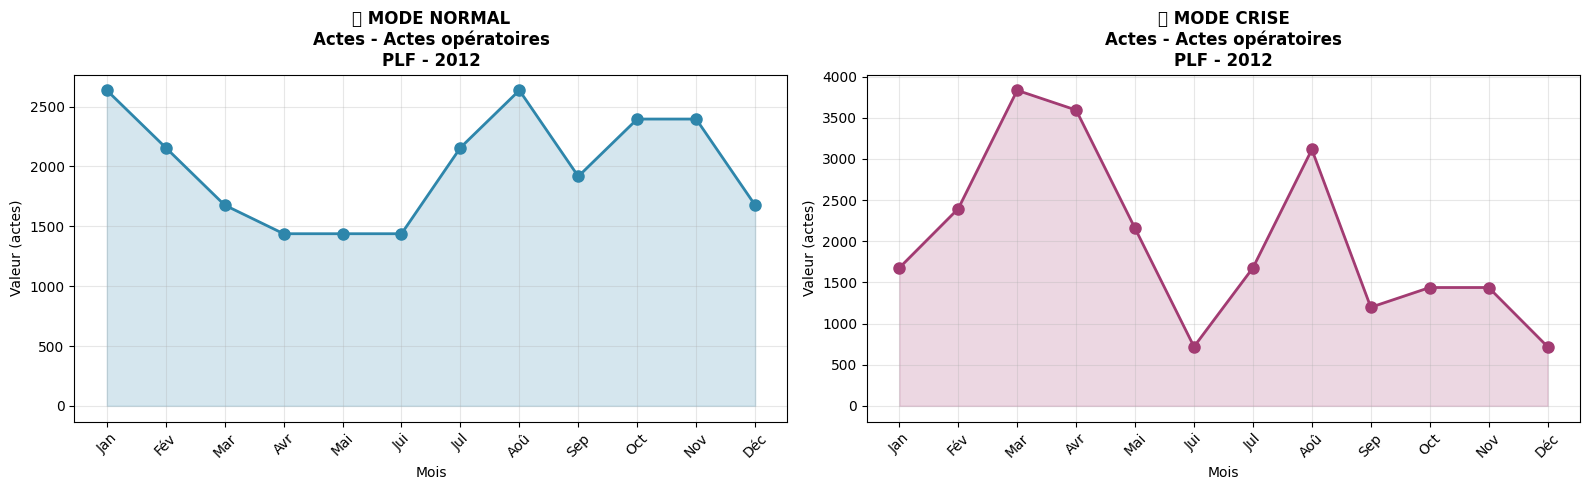


STATISTIQUES COMPARATIVES

📊 MODE NORMAL:
   Total annuel: 23963.00 actes
   Moyenne mensuelle: 1996.92 actes
   Mois max: 1 (2636.00)
   Mois min: 4 (1438.00)

🚨 MODE CRISE:
   Total annuel: 23962.00 actes
   Moyenne mensuelle: 1996.83 actes
   Mois max: 3 (3834.00)
   Mois min: 6 (719.00)

📈 ÉCARTS:
   Différence totale: -1.00 actes
   Variation: -0.0%


In [19]:
# ============================
# Graphique comparatif: MODE NORMAL vs MODE CRISE
# - Visualisation côte à côte des deux modes de saisonnalité
# - Permet de comparer l'impact de la crise sur l'activité
# ============================

import pandas as pd
import matplotlib.pyplot as plt

# 1) Chargement des données mensuelles
MONTHLY_CSV_PATH = "../data/activity-service/activity-service-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

# 2) Création de la date pour l'axe x
df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))

# 3) Paramètres de filtrage
SITE = "PLF"                    # "PLF" ou "CFX"
YEAR = 2012                     # année à visualiser
INDICATEUR = "Actes"            # utilise un indicateur qui existe réellement
SOUS_INDICATEUR = "Actes opératoires"  # optionnel, laisser "" pour ignorer

# 4) Filtrage des données
if SOUS_INDICATEUR and SOUS_INDICATEUR.strip():
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR) &
        (df["sous_indicateur"].str.strip() == SOUS_INDICATEUR.strip())
    )
else:
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR)
    )

data = df.loc[mask].copy()

if data.empty:
    print("❌ Aucune donnée trouvée.")
    print(f"\n📋 Indicateurs disponibles pour {SITE} en {YEAR}:")
    available = df[(df["site_code"] == SITE) & (df["year"] == YEAR)]["indicateur"].unique()
    for ind in sorted(available):
        print(f"   • {ind}")
else:
    # Séparation des modes
    data_normal = data[data["mode"] == "normal"].sort_values("month")
    data_crise = data[data["mode"] == "crise"].sort_values("month")
    
    unite = data["unite"].iloc[0] if "unite" in data.columns else ""
    sous_ind_display = f" - {SOUS_INDICATEUR}" if SOUS_INDICATEUR else ""
    
    # 5) Graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Graphique 1: MODE NORMAL
    if not data_normal.empty:
        axes[0].plot(data_normal["month"], data_normal["value"], "o-", color="#2E86AB", linewidth=2, markersize=8)
        axes[0].fill_between(data_normal["month"], data_normal["value"], alpha=0.2, color="#2E86AB")
        axes[0].set_title(f"📊 MODE NORMAL\n{INDICATEUR}{sous_ind_display}\n{SITE} - {YEAR}", fontsize=12, fontweight="bold")
        axes[0].set_xlabel("Mois", fontsize=10)
        axes[0].set_ylabel(f"Valeur ({unite})" if unite else "Valeur", fontsize=10)
        axes[0].grid(True, alpha=0.3)
        axes[0].set_xticks(range(1, 13))
        axes[0].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'], rotation=45)
    
    # Graphique 2: MODE CRISE
    if not data_crise.empty:
        axes[1].plot(data_crise["month"], data_crise["value"], "o-", color="#A23B72", linewidth=2, markersize=8)
        axes[1].fill_between(data_crise["month"], data_crise["value"], alpha=0.2, color="#A23B72")
        axes[1].set_title(f"🚨 MODE CRISE\n{INDICATEUR}{sous_ind_display}\n{SITE} - {YEAR}", fontsize=12, fontweight="bold")
        axes[1].set_xlabel("Mois", fontsize=10)
        axes[1].set_ylabel(f"Valeur ({unite})" if unite else "Valeur", fontsize=10)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xticks(range(1, 13))
        axes[1].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 6) Statistiques comparatives
    print("\n" + "=" * 70)
    print("STATISTIQUES COMPARATIVES")
    print("=" * 70)
    if not data_normal.empty and not data_crise.empty:
        print(f"\n📊 MODE NORMAL:")
        print(f"   Total annuel: {data_normal['value'].sum():.2f} {unite}")
        print(f"   Moyenne mensuelle: {data_normal['value'].mean():.2f} {unite}")
        print(f"   Mois max: {int(data_normal.loc[data_normal['value'].idxmax(), 'month'])} ({data_normal['value'].max():.2f})")
        print(f"   Mois min: {int(data_normal.loc[data_normal['value'].idxmin(), 'month'])} ({data_normal['value'].min():.2f})")
        
        print(f"\n🚨 MODE CRISE:")
        print(f"   Total annuel: {data_crise['value'].sum():.2f} {unite}")
        print(f"   Moyenne mensuelle: {data_crise['value'].mean():.2f} {unite}")
        print(f"   Mois max: {int(data_crise.loc[data_crise['value'].idxmax(), 'month'])} ({data_crise['value'].max():.2f})")
        print(f"   Mois min: {int(data_crise.loc[data_crise['value'].idxmin(), 'month'])} ({data_crise['value'].min():.2f})")
        
        print(f"\n📈 ÉCARTS:")
        diff = data_crise['value'].sum() - data_normal['value'].sum()
        pct_change = (data_crise['value'].sum() / data_normal['value'].sum() - 1) * 100
        print(f"   Différence totale: {diff:+.2f} {unite}")
        print(f"   Variation: {pct_change:+.1f}%")


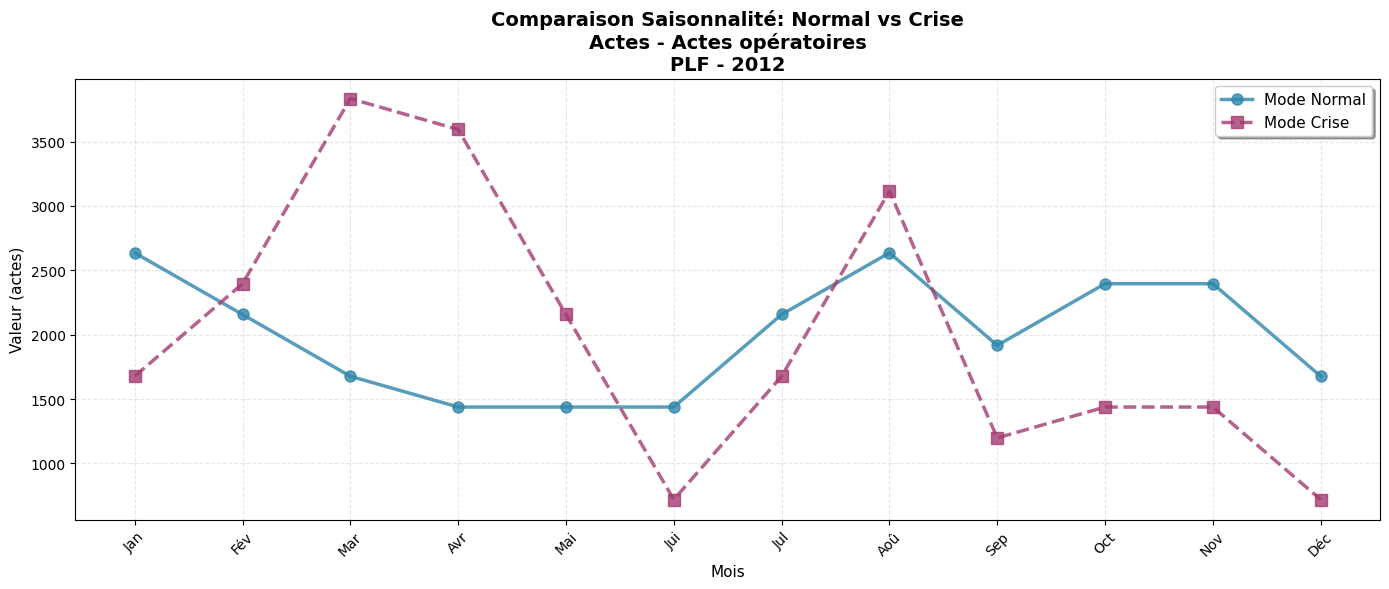


TABLEAU COMPARATIF MOIS PAR MOIS - Actes - Actes opératoires
 Mois  Normal  Crise  Écart  Variation %
    1  2636.0 1677.0 -959.0        -36.4
    2  2157.0 2396.0  239.0         11.1
    3  1677.0 3834.0 2157.0        128.6
    4  1438.0 3594.0 2156.0        149.9
    5  1438.0 2157.0  719.0         50.0
    6  1438.0  719.0 -719.0        -50.0
    7  2157.0 1677.0 -480.0        -22.3
    8  2636.0 3115.0  479.0         18.2
    9  1917.0 1198.0 -719.0        -37.5
   10  2396.0 1438.0 -958.0        -40.0
   11  2396.0 1438.0 -958.0        -40.0
   12  1677.0  719.0 -958.0        -57.1

Unité: actes


In [20]:
# ============================
# Graphique SUPERPOSÉ: MODE NORMAL vs MODE CRISE
# - Les deux modes sur le même graphique pour comparaison directe
# - Permet de voir immédiatement les différences de saisonnalité
# ============================

import pandas as pd
import matplotlib.pyplot as plt

# 1) Chargement des données mensuelles
MONTHLY_CSV_PATH = "../data/activity-service/activity-service-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

# 2) Paramètres de filtrage
SITE = "PLF"                    # "PLF" ou "CFX"
YEAR = 2012                     # année à visualiser
INDICATEUR = "Actes"            # utilise un indicateur qui existe réellement
SOUS_INDICATEUR = "Actes opératoires"  # optionnel, laisser "" pour ignorer

# 3) Filtrage des données
if SOUS_INDICATEUR and SOUS_INDICATEUR.strip():
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR) &
        (df["sous_indicateur"].str.strip() == SOUS_INDICATEUR.strip())
    )
else:
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR)
    )

data = df.loc[mask].copy()

if data.empty:
    print("❌ Aucune donnée trouvée.")
    print(f"\n📋 Indicateurs disponibles pour {SITE} en {YEAR}:")
    available = df[(df["site_code"] == SITE) & (df["year"] == YEAR)]["indicateur"].unique()
    for ind in sorted(available):
        print(f"   • {ind}")
else:
    # Séparation des modes
    data_normal = data[data["mode"] == "normal"].sort_values("month")
    data_crise = data[data["mode"] == "crise"].sort_values("month")
    
    unite = data["unite"].iloc[0] if "unite" in data.columns else ""
    sous_ind_display = f" - {SOUS_INDICATEUR}" if SOUS_INDICATEUR else ""
    
    # 4) Graphique superposé
    plt.figure(figsize=(14, 6))
    
    if not data_normal.empty:
        plt.plot(data_normal["month"], data_normal["value"], "o-", 
                color="#2E86AB", linewidth=2.5, markersize=8, label="Mode Normal", alpha=0.8)
    
    if not data_crise.empty:
        plt.plot(data_crise["month"], data_crise["value"], "s--", 
                color="#A23B72", linewidth=2.5, markersize=8, label="Mode Crise", alpha=0.8)
    
    plt.title(f"Comparaison Saisonnalité: Normal vs Crise\n{INDICATEUR}{sous_ind_display}\n{SITE} - {YEAR}", 
             fontsize=14, fontweight="bold")
    plt.xlabel("Mois", fontsize=11)
    plt.ylabel(f"Valeur ({unite})" if unite else "Valeur", fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'], rotation=45)
    plt.legend(loc='best', fontsize=11, frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()
    
    # 5) Tableau comparatif mois par mois
    if not data_normal.empty and not data_crise.empty:
        comparison = pd.DataFrame({
            "Mois": range(1, 13),
            "Normal": data_normal["value"].values,
            "Crise": data_crise["value"].values,
        })
        comparison["Écart"] = comparison["Crise"] - comparison["Normal"]
        comparison["Variation %"] = ((comparison["Crise"] / comparison["Normal"] - 1) * 100).round(1)
        
        print("\n" + "=" * 70)
        print(f"TABLEAU COMPARATIF MOIS PAR MOIS - {INDICATEUR}{sous_ind_display}")
        print("=" * 70)
        print(comparison.to_string(index=False))
        print(f"\nUnité: {unite}")


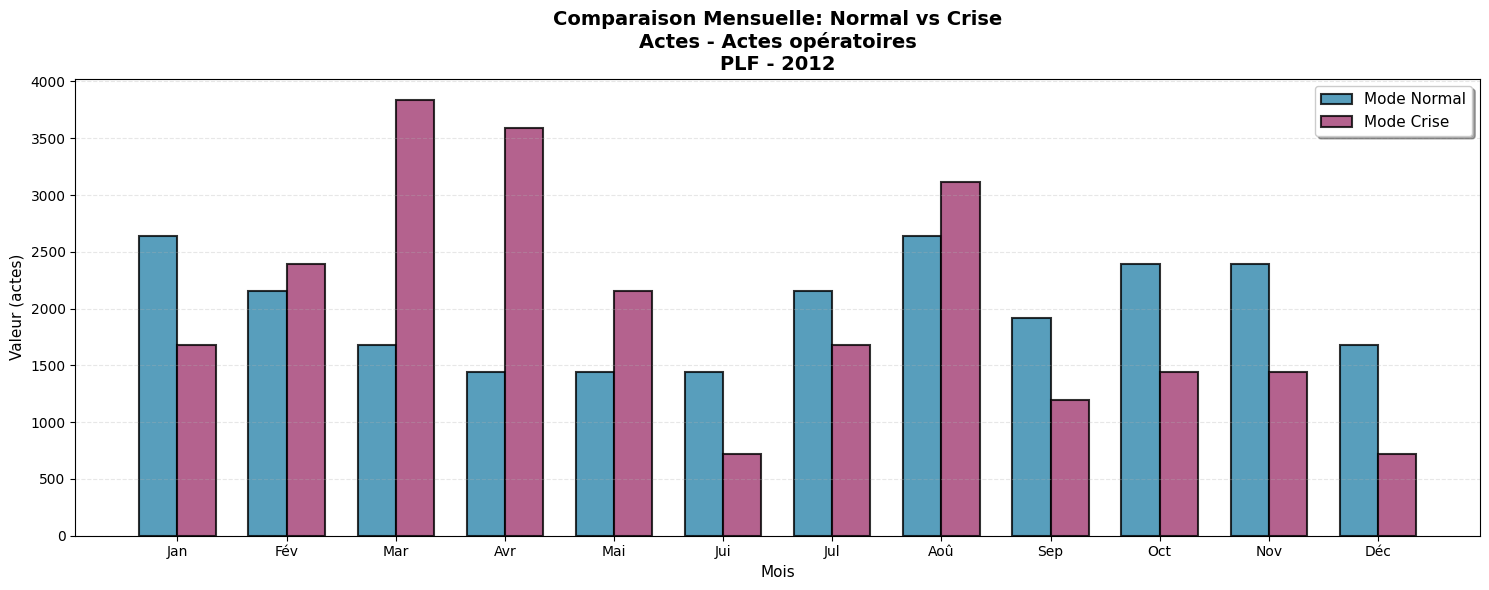


MOIS AVEC PLUS FORTE VARIATION (Crise vs Normal)
Actes - Actes opératoires - PLF - 2012
Mois  Normal  Crise  Écart  Variation %
 Avr  1438.0 3594.0 2156.0        149.9
 Mar  1677.0 3834.0 2157.0        128.6
 Mai  1438.0 2157.0  719.0         50.0
 Aoû  2636.0 3115.0  479.0         18.2
 Fév  2157.0 2396.0  239.0         11.1
 Jul  2157.0 1677.0 -480.0        -22.3
 Jan  2636.0 1677.0 -959.0        -36.4
 Sep  1917.0 1198.0 -719.0        -37.5
 Nov  2396.0 1438.0 -958.0        -40.0
 Oct  2396.0 1438.0 -958.0        -40.0
 Jui  1438.0  719.0 -719.0        -50.0
 Déc  1677.0  719.0 -958.0        -57.1


In [21]:
# ============================
# Graphique en BARRES GROUPÉES: Normal vs Crise
# - Comparaison visuelle avec barres côte à côte par mois
# - Idéal pour voir les écarts mensuels
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Chargement des données mensuelles
MONTHLY_CSV_PATH = "../data/activity-service/activity-service-donnees_mensuelles_reconstituees.csv"
df = pd.read_csv(MONTHLY_CSV_PATH)

# 2) Paramètres de filtrage
SITE = "PLF"                    # "PLF" ou "CFX"
YEAR = 2012                     # année à visualiser
INDICATEUR = "Actes"            # utilise un indicateur qui existe réellement
SOUS_INDICATEUR = "Actes opératoires"  # optionnel, laisser "" pour ignorer

# 3) Filtrage des données
if SOUS_INDICATEUR and SOUS_INDICATEUR.strip():
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR) &
        (df["sous_indicateur"].str.strip() == SOUS_INDICATEUR.strip())
    )
else:
    mask = (
        (df["site_code"] == SITE) &
        (df["year"] == YEAR) &
        (df["indicateur"].str.strip() == INDICATEUR)
    )

data = df.loc[mask].copy()

if data.empty:
    print("❌ Aucune donnée trouvée.")
    print(f"\n📋 Indicateurs disponibles pour {SITE} en {YEAR}:")
    available = df[(df["site_code"] == SITE) & (df["year"] == YEAR)]["indicateur"].unique()
    for ind in sorted(available):
        print(f"   • {ind}")
else:
    # Séparation des modes
    data_normal = data[data["mode"] == "normal"].sort_values("month")
    data_crise = data[data["mode"] == "crise"].sort_values("month")
    
    unite = data["unite"].iloc[0] if "unite" in data.columns else ""
    sous_ind_display = f" - {SOUS_INDICATEUR}" if SOUS_INDICATEUR else ""
    
    # 4) Graphique en barres groupées
    if not data_normal.empty and not data_crise.empty:
        months = np.arange(1, 13)
        x = np.arange(len(months))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(15, 6))
        
        rects1 = ax.bar(x - width/2, data_normal["value"].values, width, 
                       label='Mode Normal', color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
        rects2 = ax.bar(x + width/2, data_crise["value"].values, width, 
                       label='Mode Crise', color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1.5)
        
        ax.set_xlabel('Mois', fontsize=11)
        ax.set_ylabel(f'Valeur ({unite})' if unite else 'Valeur', fontsize=11)
        ax.set_title(f'Comparaison Mensuelle: Normal vs Crise\n{INDICATEUR}{sous_ind_display}\n{SITE} - {YEAR}', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 
                           'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
        ax.legend(fontsize=11, frameon=True, shadow=True)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        # 5) Classement des variations
        print("\n" + "=" * 70)
        print(f"MOIS AVEC PLUS FORTE VARIATION (Crise vs Normal)")
        print(f"{INDICATEUR}{sous_ind_display} - {SITE} - {YEAR}")
        print("=" * 70)
        
        variations = pd.DataFrame({
            "Mois": ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'],
            "Normal": data_normal["value"].values,
            "Crise": data_crise["value"].values,
            "Écart": (data_crise["value"].values - data_normal["value"].values),
            "Variation %": ((data_crise["value"].values / data_normal["value"].values - 1) * 100).round(1)
        })
        variations = variations.sort_values("Variation %", ascending=False)
        print(variations.to_string(index=False))


C:\Users\User\AppData\Local\Temp\ipykernel_12780\887049917.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_12780\887049917.py:61: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


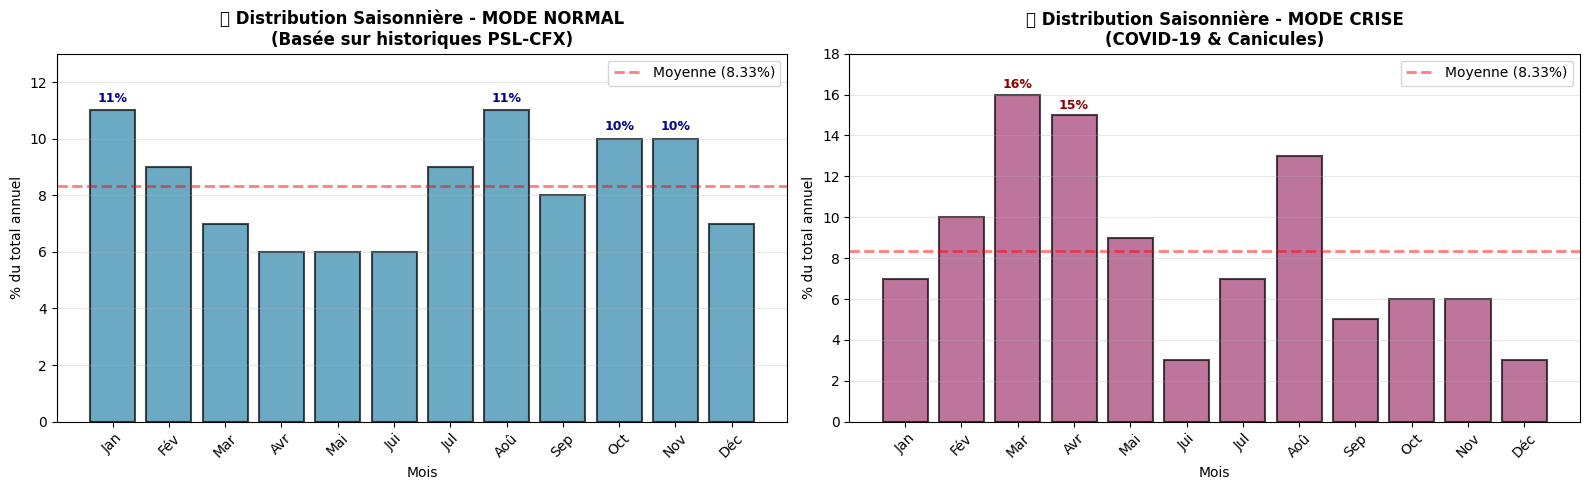


ANALYSE DES ÉCARTS DE SAISONNALITÉ

📊 Tableau comparatif des distributions:
Mois  Normal %  Crise %  Écart (pts)
 Jan        11        7           -4
 Fév         9       10            1
 Mar         7       16            9
 Avr         6       15            9
 Mai         6        9            3
 Jui         6        3           -3
 Jul         9        7           -2
 Aoû        11       13            2
 Sep         8        5           -3
 Oct        10        6           -4
 Nov        10        6           -4
 Déc         7        3           -4

🔍 Mois avec les plus grandes AUGMENTATIONS en crise:
   • Mar   : +  9.0 pts  (Normal:  7% → Crise: 16%)
   • Avr   : +  9.0 pts  (Normal:  6% → Crise: 15%)
   • Mai   : +  3.0 pts  (Normal:  6% → Crise:  9%)

📉 Mois avec les plus fortes DIMINUTIONS en crise:
   • Jan   :  -4.0 pts  (Normal: 11% → Crise:  7%)
   • Oct   :  -4.0 pts  (Normal: 10% → Crise:  6%)
   • Nov   :  -4.0 pts  (Normal: 10% → Crise:  6%)

INTERPRÉTATION
• En NORMAL:

In [22]:
# ============================
# Graphique de DISTRIBUTION %: Comparaison des saisonnalités
# - Montre la répartition mensuelle en pourcentage du total annuel
# - Permet de visualiser les pics saisonniers normaux vs crise
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Les dictionnaires doivent être définis dans la cellule 2
# On les charge ici pour référence
months_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
months = range(1, 13)

# MODE NORMAL - Profil de saisonnalité standard PSL-CFX
pct_normal = [MONTH_PCT_NORMAL[m] for m in months]

# MODE CRISE - Profil de saisonnalité en cas de crise (COVID, canicule)
pct_crise = [MONTH_PCT_CRISE[m] for m in months]

# 1) Visualisation des profils de saisonnalité (%)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Graphique 1: MODE NORMAL
axes[0].bar(months, pct_normal, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axhline(y=100/12, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Moyenne (8.33%)')
axes[0].set_title('📊 Distribution Saisonnière - MODE NORMAL\n(Basée sur historiques PSL-CFX)', 
                 fontsize=12, fontweight='bold')
axes[0].set_xlabel('Mois', fontsize=10)
axes[0].set_ylabel('% du total annuel', fontsize=10)
axes[0].set_xticks(months)
axes[0].set_xticklabels(months_labels, rotation=45)
axes[0].grid(True, axis='y', alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, max(pct_normal) + 2)

# Annotations des pics
for m, pct in zip(months, pct_normal):
    if pct >= 10:  # Marquer les mois avec ≥10%
        axes[0].text(m, pct + 0.3, f'{pct}%', ha='center', fontsize=9, fontweight='bold', color='darkblue')

# Graphique 2: MODE CRISE
axes[1].bar(months, pct_crise, color='#A23B72', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axhline(y=100/12, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Moyenne (8.33%)')
axes[1].set_title('🚨 Distribution Saisonnière - MODE CRISE\n(COVID-19 & Canicules)', 
                 fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mois', fontsize=10)
axes[1].set_ylabel('% du total annuel', fontsize=10)
axes[1].set_xticks(months)
axes[1].set_xticklabels(months_labels, rotation=45)
axes[1].grid(True, axis='y', alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_ylim(0, max(pct_crise) + 2)

# Annotations des pics
for m, pct in zip(months, pct_crise):
    if pct >= 14:  # Marquer les mois avec ≥14%
        axes[1].text(m, pct + 0.3, f'{pct}%', ha='center', fontsize=9, fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

# 2) Analyse des écarts de saisonnalité
print("\n" + "=" * 70)
print("ANALYSE DES ÉCARTS DE SAISONNALITÉ")
print("=" * 70)

ecarts = pd.DataFrame({
    "Mois": months_labels,
    "Normal %": pct_normal,
    "Crise %": pct_crise,
    "Écart (pts)": [pct_crise[i] - pct_normal[i] for i in range(12)]
})

print("\n📊 Tableau comparatif des distributions:")
print(ecarts.to_string(index=False))

print("\n🔍 Mois avec les plus grandes AUGMENTATIONS en crise:")
top_ecarts = ecarts.nlargest(3, 'Écart (pts)')
for _, row in top_ecarts.iterrows():
    print(f"   • {row['Mois']:6s}: +{row['Écart (pts)']:5.1f} pts  (Normal: {row['Normal %']:2d}% → Crise: {row['Crise %']:2d}%)")

print("\n📉 Mois avec les plus fortes DIMINUTIONS en crise:")
low_ecarts = ecarts.nsmallest(3, 'Écart (pts)')
for _, row in low_ecarts.iterrows():
    print(f"   • {row['Mois']:6s}: {row['Écart (pts)']:+5.1f} pts  (Normal: {row['Normal %']:2d}% → Crise: {row['Crise %']:2d}%)")

print("\n" + "=" * 70)
print("INTERPRÉTATION")
print("=" * 70)
print("• En NORMAL: Saisonnalité classique (hivers + été + creux printemps)")
print("• En CRISE: Concentration sur pics épidémiques (mars-avril) et canicule (août)")
print("• Réduction des activités non urgentes (avril-juin, septembre)")


# 📊 Visualisations Comparatives: Mode Normal vs Mode Crise

Ce notebook génère des données mensuelles avec **deux modes de saisonnalité**:

## Mode Normal (📊)
Basé sur la saisonnalité hospitalière standard de PSL-CFX:
- **Pics hivernaux**: Janvier-Février (grippe, infections respiratoires)
- **Pics estivaux**: Juillet-Août (canicules, isolement des aînés)
- **Périodes creuses**: Avril-Juin (printemps)

## Mode Crise (🚨)
Basé sur les crises sanitaires (COVID-19, canicules majeures):
- **Pic majeur**: Mars-Avril (confinement, saturation ED)
- **Pic secondaire**: Août (canicule exceptionnelle)
- **Compression**: Activité concentrée sur périodes de crise

## Graphiques disponibles:
1. **Côte à côte**: Deux graphiques séparés pour comparaison
2. **Superposé**: Les deux courbes sur le même graphique
3. **Barres groupées**: Comparaison mensuelle visuelle
4. **Distribution %**: Profils de saisonnalité en pourcentage
